In [1]:
# conda: xesmfTools
# xesmf 0.5.3

In [2]:
import os, sys, copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

import xarray as xr
import xesmf as xe

In [3]:
iceInput = '/mnt/BK01/mom6/glorys/GLORYS2V3_1dAV_19921231_19930101.nc'

In [4]:
# The two fields of interest are
# iicethic
# ileadfra

In [5]:
if os.path.isfile(iceInput):
    ds_disk = xr.open_dataset(iceInput)
else:
    ds_disk = xr.Dataset()

In [6]:
ds_disk

<xarray.Dataset>
Dimensions:       (depth_one: 1, deptht: 75, time_counter: 1, x: 1442, y: 1021)
Coordinates:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
  * depth_one     (depth_one) float32 1.0
  * time_counter  (time_counter) datetime64[ns] 1992-12-31T12:00:00
  * x             (x) int32 1 2 3 4 5 6 7 ... 1436 1437 1438 1439 1440 1441 1442
  * y             (y) int32 1 2 3 4 5 6 7 ... 1015 1016 1017 1018 1019 1020 1021
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Data variables: (12/14)
    sossheig      (time_counter, y, x) float32 ...
    somxlavt      (time_counter, y, x) float32 ...
    somxlt02      (time_counter, y, x) float32 ...
    somxl010      (time_counter, y, x) float32 ...
    sobarhei      (time_counter, y, x) float32 ...
    sodynhei      (time_counter, y, x) float32 ...
    ...            ...
    iicevelv      (time_counter, y, x) float32 ...
    ileadfra      (time_counter, y, x) float32 ...
    vosaline      (time_counter, deptht, y, x) float32 ...
    votemper      (time_counter, deptht, y, x) float32 ...
    vozocrtx      (time_counter, deptht, y, x) float32 ...
    vomecrty      (time_counter, deptht, y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    file_name:    GLORYS2V3_y1992m12d31_gridV.nc
    institution:  MERCATOR OCEAN
    source:       NEMO
    TimeStamp:    2013-JAN-07 04:20:15 GMT+0000
    references:   http://www.mercator-ocean.eu
    NCO:          4.3.7
    history:      Sat May 26 18:48:41 2018: ncks -A GLORYS2V3_1dAV_19921231_1...

In [7]:
plotTicks = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

/home/cermak/miniconda3/envs/xesmfTools/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


Text(0.5, 1.0, 'GLORYS(iicethic)')

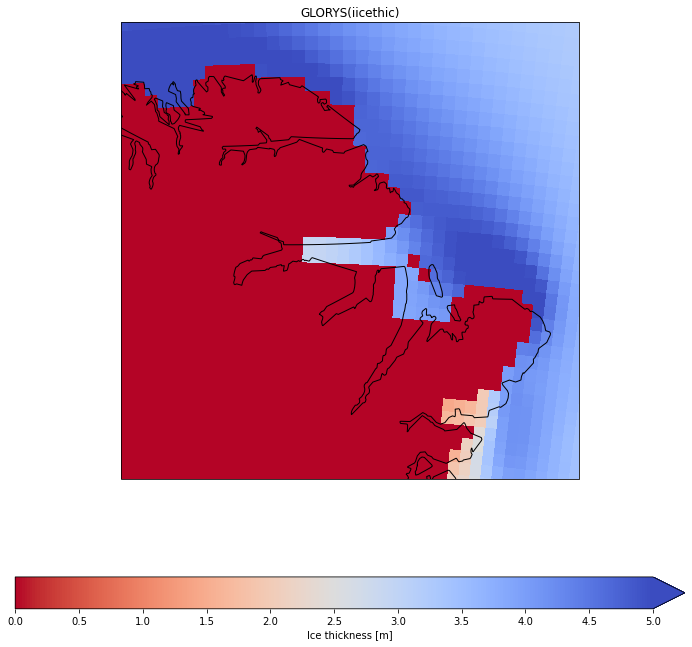

In [8]:
proj = ccrs.LambertConformal(central_longitude=-13.8)
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)
ax.set_extent([-37.5, -9.9, 80.0, 84.0])

cmap = copy.copy(mpl.cm.coolwarm_r)
cmap.set_bad(color='lightgrey')
norm = mpl.colors.Normalize(vmin=0, vmax=5)

inputData = ds_disk.iicethic

inputData.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, cbar_kwargs={'ticks': plotTicks, 'orientation': 'horizontal'})

ax.coastlines(resolution='10m')
ax.set_title('GLORYS(iicethic)')

In [9]:
# Prepare input dataset for xesmf regridding
inputData = inputData.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
inputData

<xarray.DataArray 'iicethic' (time_counter: 1, y: 1021, x: 1442)>
[1472282 values with dtype=float32]
Coordinates:
    lon           (y, x) float32 ...
    lat           (y, x) float32 ...
  * time_counter  (time_counter) datetime64[ns] 1992-12-31T12:00:00
  * x             (x) int32 1 2 3 4 5 6 7 ... 1436 1437 1438 1439 1440 1441 1442
  * y             (y) int32 1 2 3 4 5 6 7 ... 1015 1016 1017 1018 1019 1020 1021
Attributes:
    units:               m
    valid_min:           0.0
    valid_max:           100.0
    long_name:           Ice thickness
    standard_name:       sea_ice_thickness
    short_name:          iicethic
    online_operation:    N/A
    interval_operation:  86400
    interval_write:      86400
    associate:           time_counter nav_lat nav_lon

In [10]:
# Attempt to regrid this field onto the Arctic6 grid

In [11]:
gridFile = '../configs/Arctic6/roms/grid_Arctic_6.nc'
if os.path.isfile(gridFile):
    ds_grid = xr.open_dataset(gridFile)
else:
    ds_grid = xr.Dataset()
    
ds_grid = ds_grid.set_coords(['lat_rho', 'lon_rho'])

In [12]:
targetGrid = ds_grid.copy()

In [13]:
targetGrid = targetGrid.rename({'lon_rho': 'lon', 'lat_rho': 'lat', 'eta_rho': 'y', 'xi_rho': 'x'})

In [14]:
# Valid regridding algorythms: ['bilinear', 'conservative', 'conservative_normed', 'patch', 'nearest_s2d', 'nearest_d2s']
regridder = xe.Regridder(inputData, targetGrid, 'nearest_s2d', ignore_degenerate=True)

/home/cermak/miniconda3/envs/xesmfTools/lib/python3.7/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [15]:
regridder

xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_1021x1442_1394x1082.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1021, 1442) 
Output grid shape:          (1394, 1082) 
Periodic in longitude?      False

In [16]:
outputGrid = regridder(inputData)

/home/cermak/miniconda3/envs/xesmfTools/lib/python3.7/site-packages/xesmf/frontend.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


Text(0.5, 1.0, 'GLORYS(iicethic) on ROMS grid')

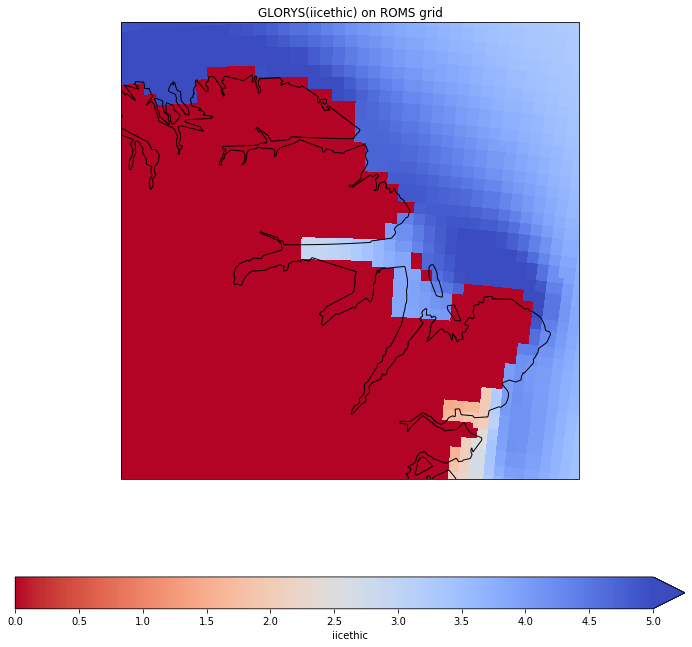

In [17]:
proj = ccrs.LambertConformal(central_longitude=-13.8)
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)
ax.set_extent([-37.5, -9.9, 80.0, 84.0])

cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=0, vmax=5)

outputGrid.plot(x='lon', y='lat', transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, cbar_kwargs={'ticks': plotTicks, 'orientation': 'horizontal'})

ax.coastlines(resolution='10m')
ax.set_title('GLORYS(iicethic) on ROMS grid')

Text(0.5, 1.0, 'ROMS(mask_rho)')

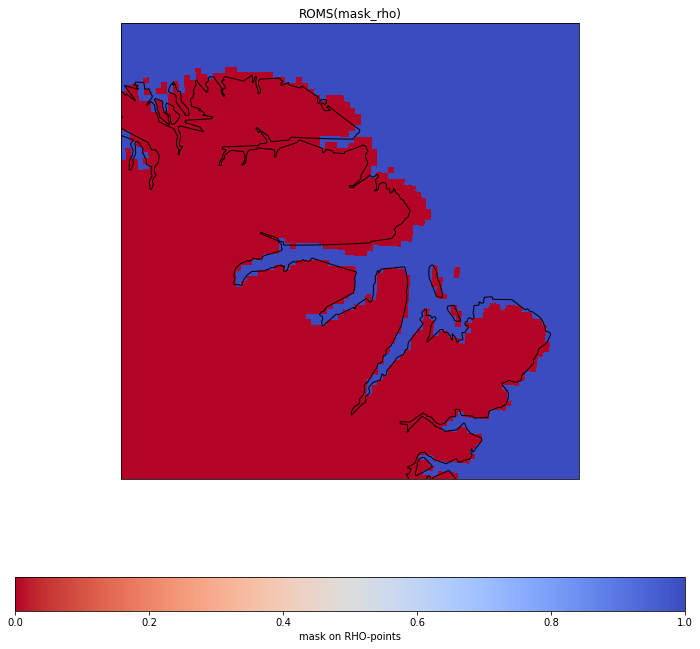

In [18]:
mask_rho = ds_grid.mask_rho
proj = ccrs.LambertConformal(central_longitude=-13.8)
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)
ax.set_extent([-37.5, -9.9, 80.0, 84.0])

cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

mask_rho.plot(x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, cbar_kwargs={'orientation': 'horizontal'})
#mask_rho.plot(x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, cbar_kwargs={'ticks': elevLev, 'orientation': 'horizontal'})

#coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
#                                        edgecolor='k', facecolor='0.8')
#ax.add_feature(coast_10m)
ax.coastlines(resolution='10m')
ax.set_title('ROMS(mask_rho)')

In [19]:
# Delete time_counter dimension
del outputGrid['time_counter']

In [20]:
outputGrid = outputGrid.squeeze()

In [21]:
targetGrid['hice'] = (('y','x'), outputGrid)

Text(0.5, 1.0, 'ROMS(hice)')

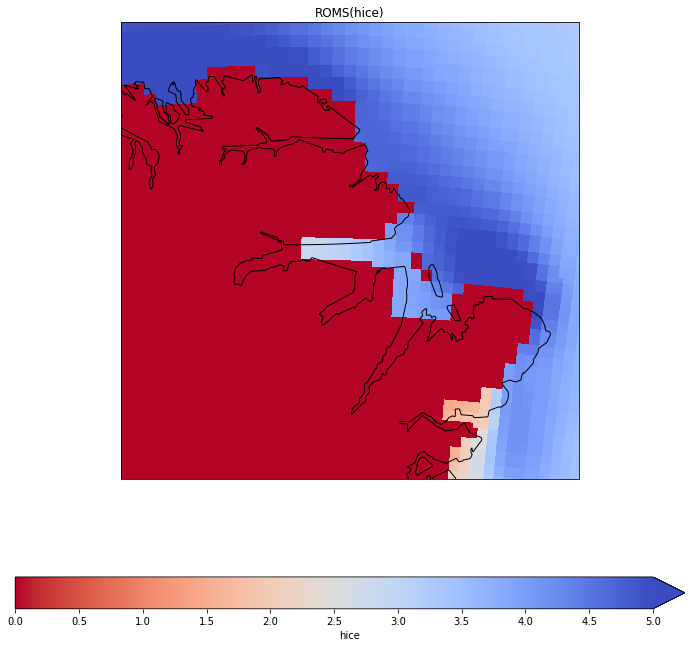

In [22]:
proj = ccrs.LambertConformal(central_longitude=-13.8)
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)
ax.set_extent([-37.5, -9.9, 80.0, 84.0])

cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=0, vmax=5)

targetGrid.hice.plot(x='lon', y='lat', transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, cbar_kwargs={'ticks': plotTicks, 'orientation': 'horizontal'})

ax.coastlines(resolution='10m')
ax.set_title('ROMS(hice)')

In [23]:
targetGrid.to_netcdf('arctic6.nc')